# Multi-Source Domain Adaptation for Classification

By Yuanhao Zhang, 20658228, y2384zha@uwaterloo.ca

### ABSTRACT
The success of machine learning methods on computer vision and visual recognition is highly dependent on the large labeled dataset. However, it's often ignorant that when the dataset are from different domains in which the training process did not see. This will generally result in large drops in the performance of the neural network. 

In this notebook, I participated in VisDA 2019 challenge. Instead of regular participants where they would train using images from different domains and test a unseen targeted domain, I would, in contract, train on a specific domain. With the trained model, I will then compare the performance of my trained model on unseen images from different domains. 

In the first section of this notebook, I first introduced a couple preliminary tools that I will be using later. It's important to download and load VisDA 2019 challenge dataset. Following that, I will define the necessary modules and libraries that I would be using in this notebook. 

In the second section, I start attempting the problem with a simple CNN model. There are 6 different domains of images, clipart, infograph, real, sketch, painting, and quickdraw. I used this simple CNN model to train on clipart. I will then observe the performance of this model when predicting unseen test set from clipart images as well as unseen test images from all other domains.

In the third section, I essentially did similar attempt in Section Two. However, instead of using simple CNN model, I used the Multi-Source Domain Adaptation architecture given by the VisDA 2019 challenge to train a Domain Adaptation Neural Network(DANN). The image of this architecture is presented in Section Three. Then, I will compare and contrast the performance of the model between DANN and Simple CNN.


## Section One: Preliminary Tools and Setup
In Section One, it's essentially setting up the project. It will need to download the data from "http://csr.bu.edu/ftp/visda/2019/multi-source/". Then, we follow by the instruction to split the data set into training and test set using custom DataSet and DataLoader. We show a couple of sample images from the training set and its corresponding label.

### Packages for Downloading Dataset

In [50]:
import urllib.request
import zipfile
import os

In [54]:
# Downloading Training Images
train_styles = ['clipart.zip']
test_styles = ['quickdraw.zip', 'infograph.zip', 'painting.zip', 'real.zip', 'sketch.zip']
download_url = 'http://csr.bu.edu/ftp/visda/2019/multi-source/'

for style in train_styles:
    filename = style.split('.')[0]
    if os.path.isdir('data/' + filename):
        print(style + ' fully downloaded')
        continue
        
    if os.path.isfile(style):
        print(style + " downloaded")
    else:
        urllib.request.urlretrieve(download_url + 'groundtruth/' + style, style)
        print("Finished downloading " + style)
        
    if os.path.isdir('data/' + filename):
        print(style + ' unzipped')
    else:
        with zipfile.ZipFile(style, "r") as zip_ref:
            zip_ref.extractall("data/")
        print("Finished unzipping " + style)
        
# Downloading Test Images
for style in test_styles:
    filename = style.split('.')[0]
    if os.path.isdir('data/' + filename):
        print(style + ' fully downloaded')
        continue
        
    if os.path.isfile(style):
        print(style + " downloaded")
    else:
        urllib.request.urlretrieve(download_url + style, style)
        print("Finished downloading " + style)
        
    if os.path.isdir('data/' + filename):
        print(style + ' unzipped')
    else:
        with zipfile.ZipFile(style, "r") as zip_ref:
            zip_ref.extractall("data/")
        print("Finished unzipping " + style)

clipart.zip fully downloaded
Finished downloading quickdraw.zip
quickdraw.zip unzipped


In [3]:
# Downloading train/test splits
train_test_split = ['clipart', 'infograph', 'painting', 'quickdraw', 'real', 'sketch']
train_test_split_url = 'http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/'

for style in train_test_split:
    if os.path.isfile('labels/' + style + '_train.txt'):
        print(style + " train.txt and test.txt downloaded")
        continue
    urllib.request.urlretrieve(train_test_split_url + style + '_train.txt', 'labels/' + style + '_train.txt')
    urllib.request.urlretrieve(train_test_split_url + style + '_test.txt', 'labels/' + style + '_test.txt')
    print(style + ' train and test txt downloaded')

clipart train.txt and test.txt downloaded
infograph train.txt and test.txt downloaded
painting train.txt and test.txt downloaded
quickdraw train.txt and test.txt downloaded
real train.txt and test.txt downloaded
sketch train.txt and test.txt downloaded


### Import Packages

In [4]:
%matplotlib inline
USE_GPU = False

# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, transform

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

### Loading Data using DataLoader

In [25]:
# Define constants and utility values
DATASET = 'data/'
LABEL = 'labels/'
image_size = 256
train_batch_size = 16
test_batch_size = 4
num_classes = 10

norm = ([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])

names = {}
for line in open("labels/clipart_train.txt"):
    data = line.strip().split(' ')
    names[data[1]] = data[0].split("/")[1]
    
    
# UnNormalize the images
invTrans = transforms.Compose([transforms.Normalize([ 0., 0., 0. ], [ 1/0.229, 1/0.224, 1/0.225 ]),
                               transforms.Normalize([ -0.485, -0.456, -0.406 ], [ 1., 1., 1. ])])

# Regular Transformation
data_transformation = transforms.Compose([transforms.Resize([image_size, image_size]), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(*norm)])

In [26]:
class VisDADataSet(Dataset):
    def __init__(self, root, dataset, transformation=None):
        self.root = root
        self.transformation = transformation
        
        images = []        
        for data in dataset:
            style = data[0]
            path = root + data[1][0]
            label = data[1][1]
            if int(label) < num_classes:
                images.append((style, path, label))
        self.images = images
            
    def __getitem__(self, index):
        style, path, label = self.images[index]
        img = Image.open(path).convert("RGB")
        img = self.transformation(img)
        return img, label, style
        
    def __len__(self):
        return len(self.images)
    
def create_VisDA_dataset(root, labels_dir, data_transformation, styles, isTrain):
    dataset = 'train' if isTrain else 'test'
    res = []
    for i, style in enumerate(styles):
        file = labels_dir + style + "_" + dataset + '.txt'
        for line in open(file):
            res.append((i, line.strip().split(' ')))
    return VisDADataSet(root, res, data_transformation)

### Sample Images From Training Set

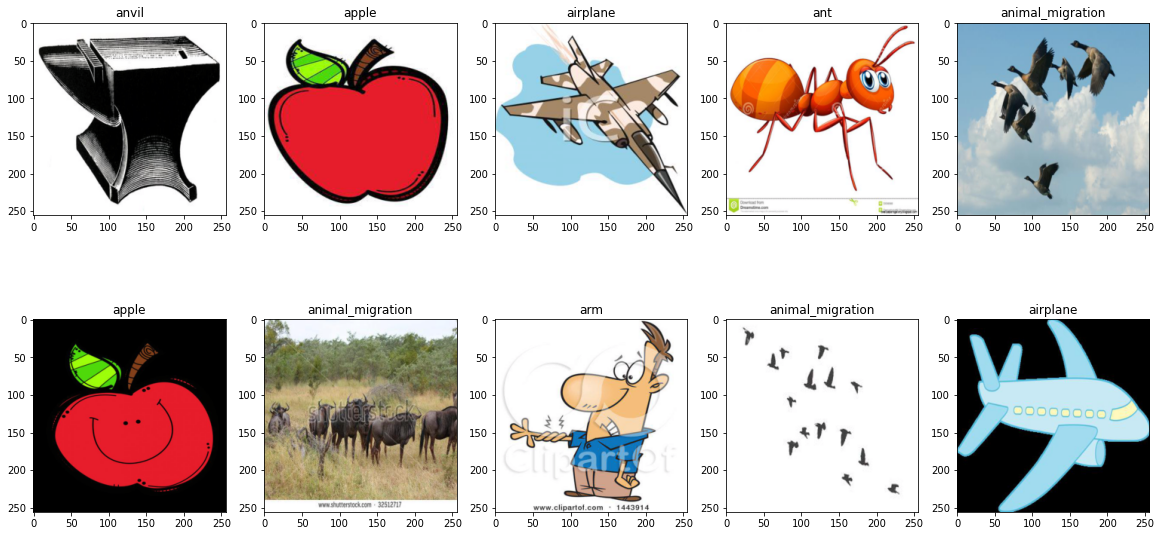

In [27]:
training = create_VisDA_dataset(DATASET, LABEL, data_transformation, ['clipart'], True)
total = len(training)
random_indices = random.sample(range(total), 10)

fig = plt.figure(figsize=(20, 20))

for i, index in enumerate(random_indices):
    image, label, style = training[index]
    image = invTrans(image)
    tF.to_pil_image(image)
    ax = fig.add_subplot(i//5+1, 5, i+1)
    plt.title(names[label])
    ax.imshow(tF.to_pil_image(image))
    
plt.show()

### Create Training and Test Dataset for VisDA

In [28]:
train_test_split = ['clipart', 'infograph', 'painting', 'quickdraw', 'real', 'sketch']

# Create Training and Testing Dataset
train_data = create_VisDA_dataset(DATASET, LABEL, data_transformation, train_test_split[:1], True)
test_data1 = create_VisDA_dataset(DATASET, LABEL, data_transformation, train_test_split[:1], False)

test_data2 = create_VisDA_dataset(DATASET, LABEL, data_transformation, train_test_split[1:], False)

In [29]:
print("Clipart Training Data Size: " + str(len(train_data)))
print("Clipart Test Data Size: " + str(len(test_data1)))
print("Infograph, Painting, Quickdraw, Real, Sketch Test Data Size: " + str(len(test_data2)))

Clipart Training Data Size: 705
Clipart Test Data Size: 308
Infograph, Painting, Quickdraw, Real, Sketch Test Data Size: 4040


### Create Training and Test DataLoader

In [30]:
train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=0)
test_dataloader1 = DataLoader(test_data1, batch_size=test_batch_size, shuffle=True, num_workers=0)
test_dataloader2 = DataLoader(test_data2, batch_size=test_batch_size, shuffle=True, num_workers=0)

## Section Two: Simple NN Model Training and Validation

### Intermediary Summary
Up until this point, we have finished most of the basic setup step. In this section, we will introduce a simple neural network model. We will use the model to train on a small subset of the training set and test the two different test sets and compare the results.

### Simple CNN Model using Pretrained ResNet 

In [31]:
import torchvision.models as models

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)
        self.num_classes = num_classes
        
        # residual blocks from resnet
        resnet = models.resnet18(pretrained=True)
        self.layer1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer2 = resnet.layer1
        self.layer3 = resnet.layer2
        self.layer4 = resnet.layer3
        self.layer5 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(512, num_classes)
        self.fc2 = nn.Conv2d(512, num_classes, 2, padding=1)

    def forward(self, x, gts=None):
        width = x.shape[2]
        height = x.shape[3]
        shape = (width,height)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(self.layer5(x))
        
        out = torch.flatten(x, 1)
        out = self.fc(out)
        
        x = self.fc2(x)
        x = nn.functional.interpolate(x, size=shape, mode='bilinear')
        
        p1 = F.softmax(x, dim=1)
        p2 = F.softmax(out, dim=1)
        
        if gts is not None:
            return p1, p2, self.criterion(p2, gts)
        else:
            return p1, p2

In [32]:
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

### Validate the accuracy of the Untrained Net 

Untrained net prediction of the ground truth for the target image.

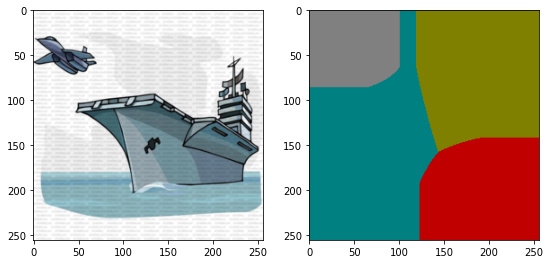

In [34]:
untrained_net = SimpleCNN(num_classes).eval()

image, label, style = train_data[0]
untrained_output = untrained_net.forward(image[None])

fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(1,3,1)
image = invTrans(image)
ax.imshow(tF.to_pil_image(image))

ax = fig.add_subplot(1,3,2)
ax.imshow(colorize_mask(torch.argmax(untrained_output[0], dim=1).numpy()[0]))
plt.show()

Untrained net prediction result and actual label on 10 randomly selected images.

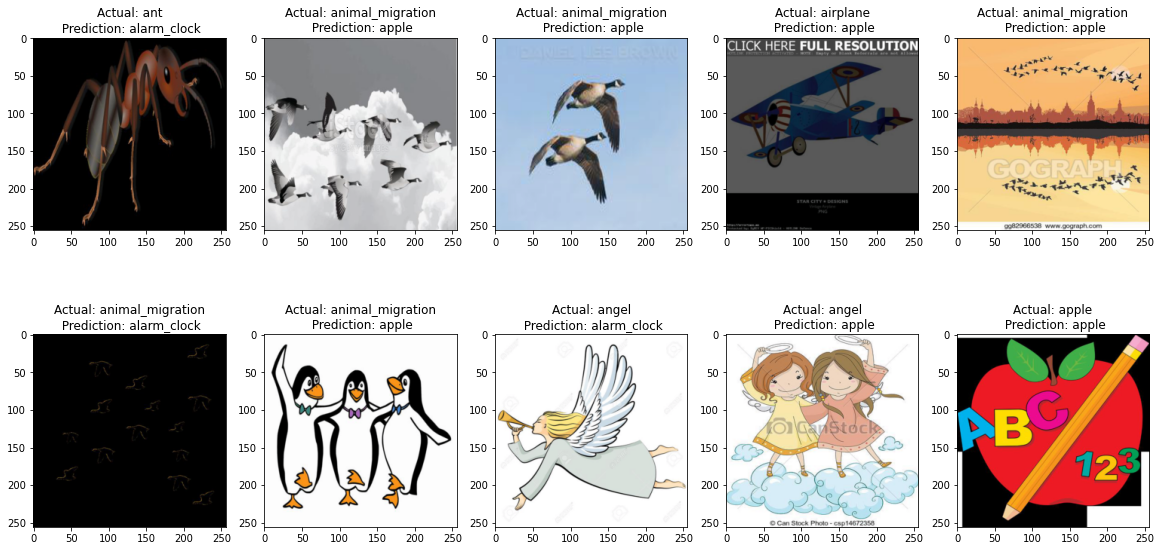

In [35]:
random_indices = random.sample(range(total), 10)

fig = plt.figure(figsize=(20, 20))

for i, index in enumerate(random_indices):
    image, label, style = train_data[index]
    image = invTrans(image)
    tF.to_pil_image(image)
    
    output = untrained_net.forward(image[None])[1]
    pred = int(torch.argmax(output))
    
    ax = fig.add_subplot(i//5+1, 5, i+1)
    plt.title('Actual: ' + names[str(label)] + '\n Prediction: ' + names[str(pred)])
    ax.imshow(tF.to_pil_image(image))
    
plt.show()

In [36]:
def validate(val_loader, net):
    net.eval()
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, masks, style = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = masks.cuda()
                net = net.cuda()

            output = net(inputs)[1]
            masks = torch.from_numpy(np.asarray(masks, dtype=np.long))
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(masks.view_as(pred)).sum().item()
    
    return correct / len(val_loader.dataset)

Here we compute the accuracy of the untrained model on the dataset.

In [20]:
res = validate(train_dataloader, untrained_net)
print("Clipart Prediction Accuracy using Untrained Net on Training Set: " + str(res))

Clipart Prediction Accuracy using Untrained Net on Training Set: 0.08794326241134752


### Training the Basic CNN Model

Define optimizer to train the given loss function

In [37]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.005,
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer

In [38]:
def train(train_loader, net, optimizer, loss_graph):
    
    losses = []
    
    for i, data in enumerate(train_loader):
        inputs, masks, style = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            target = target.cuda()
            
        masks = torch.from_numpy(np.asarray(masks, dtype=np.long))
        
        optimizer.zero_grad()
        main_loss = net(inputs, gts=masks)[2]
        losses.append(main_loss.item())
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()

    return np.mean(np.array(losses))

In [39]:
%%time
%matplotlib notebook
simple_net = copy.deepcopy(untrained_net)

# You can change the number of EPOCHS
EPOCH = 10

# switch to train mode (original untrained_net was set to eval mode)
simple_net.train()

optimizer = get_optimizer(simple_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_dataloader, simple_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for SIMPLE_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

Starting Training...


<IPython.core.display.Javascript object>

Epoch: 0 Loss: 2.266258388095432
Epoch: 1 Loss: 2.0893327262666492
Epoch: 2 Loss: 1.9795140637291802
Epoch: 3 Loss: 1.9176108360290527
Epoch: 4 Loss: 1.8748771985371908
Epoch: 5 Loss: 1.8153210401535034
Epoch: 6 Loss: 1.77229991224077
Epoch: 7 Loss: 1.7353145175509983
Epoch: 8 Loss: 1.6981547832489015
Epoch: 9 Loss: 1.6656320571899415
CPU times: user 32min 25s, sys: 4min 27s, total: 36min 53s
Wall time: 28min 17s


Simple_net prediction and actual label on 10 randomly selected images.

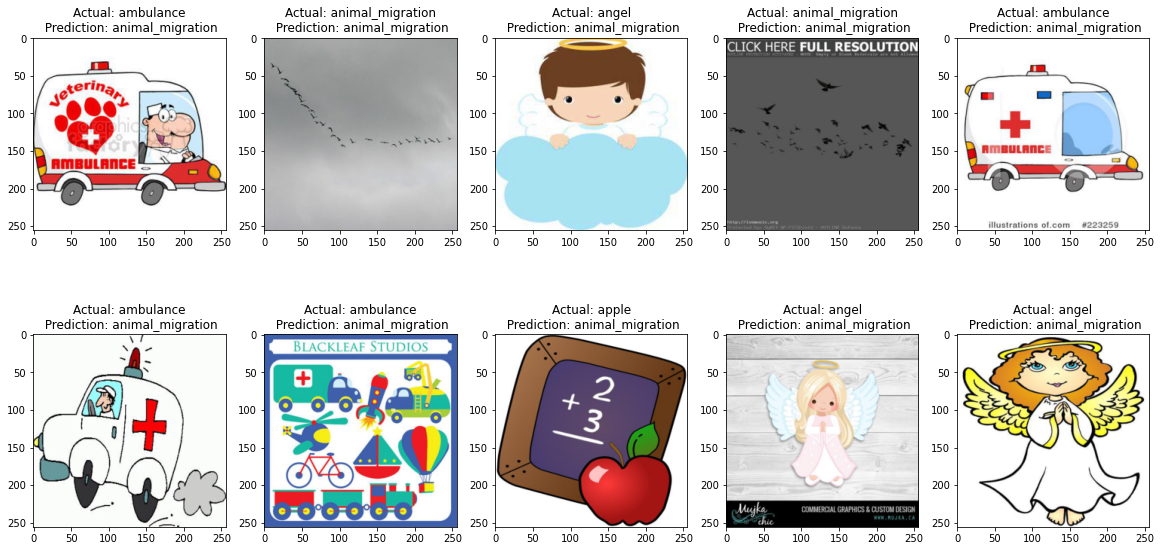

In [40]:
random_indices = random.sample(range(total), 10)

fig = plt.figure(figsize=(20, 20))

for i, index in enumerate(random_indices):
    image, label, style = train_data[index]
    image = invTrans(image)
    tF.to_pil_image(image)
    
    output = simple_net.forward(image[None])[1]
    pred = int(torch.argmax(output))
    
    ax = fig.add_subplot(i//5+1, 5, i+1)
    plt.title('Actual: ' + names[str(label)] + '\n Prediction: ' + names[str(pred)])
    ax.imshow(tF.to_pil_image(image))
    
plt.show()

In [41]:
res = validate(test_dataloader1, simple_net)
print("Clipart Prediction Accuracy using Untrained Net on Test Set: " + str(res))

Clipart Prediction Accuracy using Untrained Net on Test Set: 0.8766233766233766


In [42]:
res = validate(test_dataloader2, simple_net)
print("Infograph, Real, Quickdraw, Painting, Sketch Prediction Accuracy on Unseen Test Set: " + str(res))

Infograph, Real, Quickdraw, Painting, Sketch Prediction Accuracy on Unseen Test Set: 0.3349009900990099


At this point, I see that the performance of the simple CNN model is disappointing but expected. I trained the model on Clipart training images for 10 epochs, and it gives 88% of accuracy on unseen Clipart test images. This is an indication that our model is capable of extracting and learning the clipart images features. However, when this model is used to evaluate unseen different styles of images such as sketch, painting, etc., the performance is terrible. 

I am using a tiny subset, 10 objects, of the entire image set. This implies that even random guessing will gives an accuracy of around 10%. Our simple model is able to extract certain features of other unseen styles but it's not as good as anticipated. In the following, we will use Domain-Adapation Neural Network.

## Section 3: Domain Adaptation Neural Network (DANN)

### Loading Data

In [49]:
num_classes = 10
train_batch_size = 16
test_batch_size = 4

train_test_split = ['clipart', 'infograph', 'painting', 'quickdraw', 'real', 'sketch']

# Create Training and Testing Dataset
train_data = create_VisDA_dataset(DATASET, LABEL, data_transformation, train_test_split[:1], True)
test_data1 = create_VisDA_dataset(DATASET, LABEL, data_transformation, train_test_split[:1], False)

test_data2 = create_VisDA_dataset(DATASET, LABEL, data_transformation, train_test_split[1:], False)

print("Clipart Training Data Size: " + str(len(train_data)))
print("Clipart Test Data Size: " + str(len(test_data1)))
print("Infograph, Painting, Quickdraw, Real, Sketch Test Data Size: " + str(len(test_data2)))

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=0)
test_dataloader1 = DataLoader(test_data1, batch_size=test_batch_size, shuffle=True, num_workers=0)
test_dataloader2 = DataLoader(test_data2, batch_size=test_batch_size, shuffle=True, num_workers=0)

Clipart Training Data Size: 705
Clipart Test Data Size: 308
Infograph, Painting, Quickdraw, Real, Sketch Test Data Size: 4040


### Defining Domain Adaptation Neural Network
Using the model specified in the image.

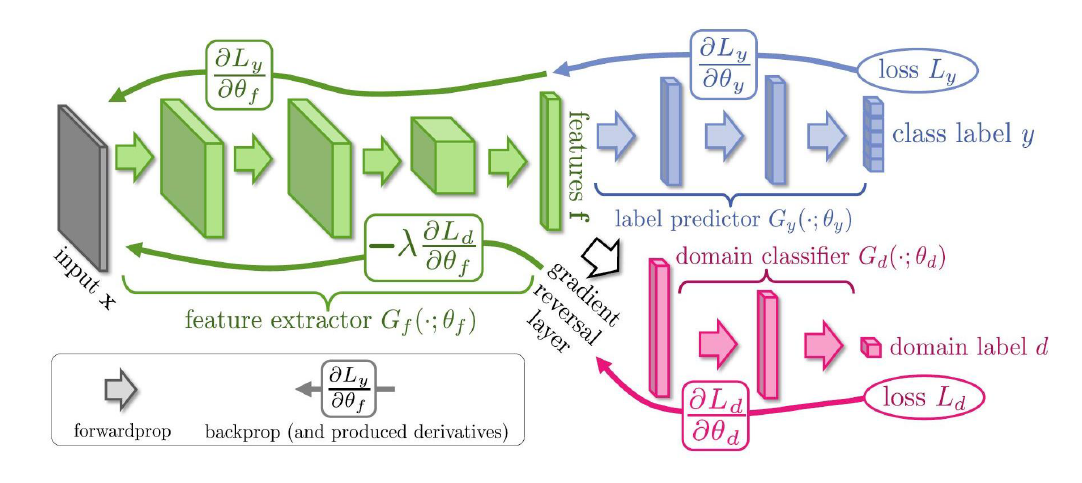

In [12]:
from IPython.display import Image as ImageLoader
from IPython.display import display

imagePath = 'DANN.png'
display(ImageLoader(filename=imagePath))

In [13]:
from torch.autograd import Function

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

def grad_reverse(x):
    return GradReverse.apply(x)

In [19]:
import torchvision.models as models

class DANN(nn.Module):
    def __init__(self, num_classes):
        super(DANN, self).__init__()
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)
        self.num_classes = num_classes
        
        # Feature Extractor
        resnet = models.resnet18(pretrained=True)
        self.layer1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer2 = resnet.layer1
        self.layer3 = resnet.layer2
        self.layer4 = resnet.layer3
        self.layer5 = resnet.layer4
        self.avgpool = resnet.avgpool
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
        # Domain Classifier
        self.domain_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
        

    def forward(self, x, gts=None):
        # Feature Extractor
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(self.layer5(x))
        x = torch.flatten(x, 1)
        
        # Classifier
        out1 = self.classifier(x)
        out1 = F.softmax(out1, dim=1)
        
        # Domain Classifier
        out2 = grad_reverse(x)
        out2 = self.domain_classifier(out2)
        
        return out1, out2

In [20]:
model_DANN = DANN(num_classes)

In [21]:
def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        inputs, masks, style = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            target = target.cuda()
            
        masks = torch.from_numpy(np.asarray(masks, dtype=np.long))
        style = torch.from_numpy(np.asarray(style, dtype=np.long))
        
        optimizer.zero_grad()
        class_output, domain_output = net(inputs, gts=masks)
        class_loss = F.cross_entropy(class_output, masks)
        domain_loss = F.cross_entropy(domain_output, masks)
        main_loss = class_loss + 0.1 * domain_loss
        
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()

    return main_loss

In [22]:
%%time
%matplotlib notebook

# You can change the number of EPOCHS
EPOCH = 10

# switch to train mode (original untrained_net was set to eval mode)
model_DANN.eval()

optimizer = torch.optim.Adam(model_DANN.parameters(), lr = 0.0001)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_dataloader, model_DANN, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for Domain Adaptation Neural Network')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

Starting Training...


<IPython.core.display.Javascript object>

Epoch: 0 Loss: 1.9951443672180176
Epoch: 1 Loss: 1.0508344173431396
Epoch: 2 Loss: 1.0077128410339355
Epoch: 3 Loss: 2.0773873329162598
Epoch: 4 Loss: 1.0024542808532715
Epoch: 5 Loss: 0.9978687763214111
Epoch: 6 Loss: 0.9982258081436157
Epoch: 7 Loss: 1.0141493082046509
Epoch: 8 Loss: 1.0727159976959229
Epoch: 9 Loss: 1.787617802619934
CPU times: user 12min 28s, sys: 1min 53s, total: 14min 22s
Wall time: 11min 50s


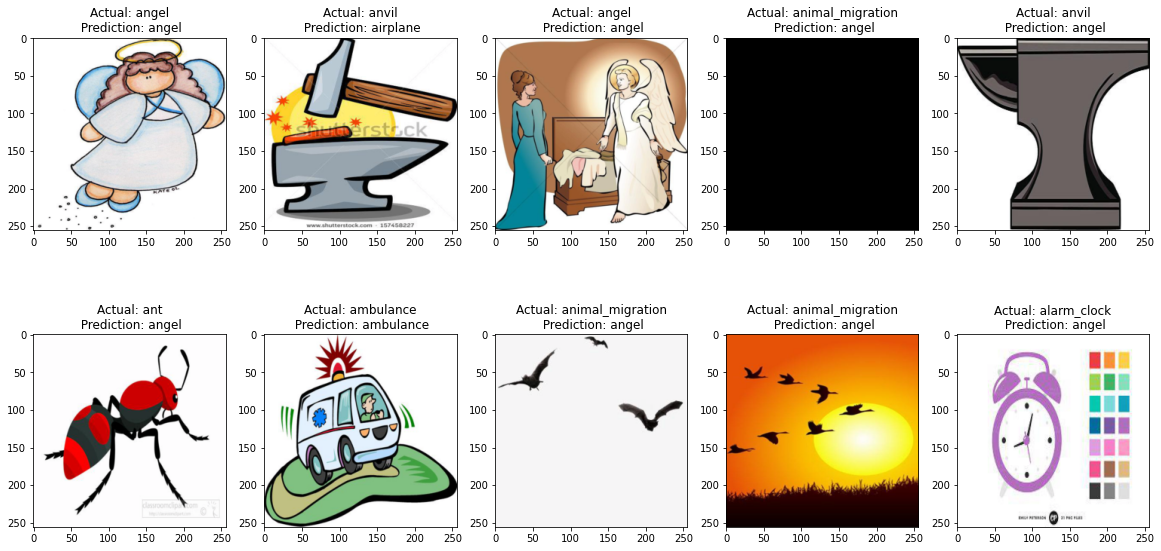

In [44]:
random_indices = random.sample(range(total), 10)

fig = plt.figure(figsize=(20, 20))

for i, index in enumerate(random_indices):
    image, label, style = train_data[index]
    image = invTrans(image)
    tF.to_pil_image(image)
    
    output = model_DANN.forward(image[None])[1]
    pred = int(torch.argmax(output))
    
    ax = fig.add_subplot(i//5+1, 5, i+1)
    plt.title('Actual: ' + names[str(label)] + '\n Prediction: ' + names[str(pred)])
    ax.imshow(tF.to_pil_image(image))
    
plt.show()

In [23]:
res = validate(test_dataloader1, model_DANN)
print("Clipart Prediction Accuracy using DANN Net on Test Set: " + str(res))

Clipart Prediction Accuracy using DANN Net on Test Set: 0.849624060150376


In [24]:
res = validate(test_dataloader2, model_DANN)
print("Clipart Prediction Accuracy using DANN Net on Test Set: " + str(res))

Clipart Prediction Accuracy using DANN Net on Test Set: 0.5010204081632653


## Section Four: Conclusion

This part will summarize the result from this notebook. 

There are 6 different domains of images, clipart, infograph, real, sketch, painting, and quickdraw. I used a simple model from pretrained ResNet-18 to train on a portion of clipart images. 

In Section Two, after training for 10 epochs, we see that the model predicted 87% of images correctly when I feed the model with unseen clipart images. However, it only predicted 33% of images correctly when I feed images from other domains. The result is understandable because the model have never learned and extracted features of images of other domains. 

In Section Three, after training for 10 epochs on the exact same dataset but using a Domain Adapted Neural Network, the model predicted about 50% correct on images from other domains. This implies that our DANN model is indeed better than the simple NN model. Although 50% isn't high, it is definitely an improvement.

However, 50% of accuracy is for sure not enough. In the following, I summarized on how I can improve the correctness. I believe that the model will perform much better if I train on multiple sources of domains. For example, if I train four domains and used the other two as a measurement of the model, I believe that the performance will improve significantly, and I believe that the Domain Adapation framework is indeed helpful when predicting images from different domains and styles.